Epoch 1, Loss: 3.9600
Epoch 2, Loss: 3.5722
Epoch 3, Loss: 3.5060
Epoch 4, Loss: 3.4807
Epoch 5, Loss: 3.4701
Epoch 6, Loss: 3.4639
Epoch 7, Loss: 3.4602
Epoch 8, Loss: 3.4580
Epoch 9, Loss: 3.4566
Epoch 10, Loss: 3.4557


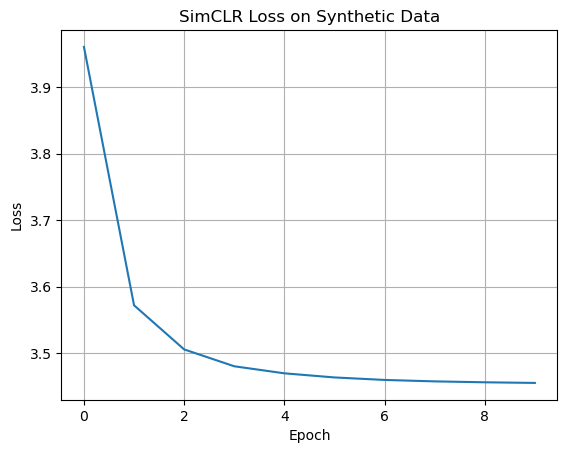

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# SimCLR encoder + projection head
class SimCLR(nn.Module):
    def __init__(self, encoder_dim=64, projection_dim=32):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3 * 16 * 16, encoder_dim),
            nn.ReLU()
        )
        self.projector = nn.Sequential(
            nn.Linear(encoder_dim, encoder_dim),
            nn.ReLU(),
            nn.Linear(encoder_dim, projection_dim)
        )

    def forward(self, x):
        features = self.encoder(x)
        projection = self.projector(features)
        return F.normalize(projection, dim=1)

# NT-Xent Loss
def nt_xent_loss(z1, z2, temperature=0.5):
    # Number of samples in each view
    N = z1.size(0)

    # Concatenate both views: shape (2N, D)
    z = torch.cat([z1, z2], dim=0)

    # Compute cosine similarity between all (2N x 2N) pairs
    # Divide by temperature to control distribution sharpness
    sim = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2) / temperature

    # Create a mask to ignore self-similarities (i == j)
    mask = torch.eye(2 * N, dtype=torch.bool).to(z.device)
    sim.masked_fill_(mask, -9e15)  # Set diagonal to large negative value

    # Construct index of positive pairs:
    # For i in z1: positive is i + N in z2
    # For i in z2: positive is i - N in z1
    pos = torch.cat([torch.arange(N, 2 * N), torch.arange(N)]).to(z.device)

    # Numerator: similarity with the positive pair only
    numerator = torch.exp(sim[torch.arange(2 * N), pos])

    # Denominator: sum of similarities with all other examples
    denominator = torch.exp(sim).sum(dim=1)

    # Return the mean of log-softmax (cross entropy) loss
    return -torch.log(numerator / denominator).mean()

# Generate synthetic data
def generate_data(N=32):
    half = N // 2
    class1 = torch.randn(half, 3, 16, 16) * 0.2 + 0.5
    class2 = torch.randn(half, 3, 16, 16) * 0.2 - 0.5
    return torch.cat([class1, class2], dim=0)

# Train
model = SimCLR()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
losses = []

for epoch in range(10):
    x = generate_data()
    x1 = x + 0.05 * torch.randn_like(x)
    x2 = torch.roll(x, shifts=1, dims=3) + 0.05 * torch.randn_like(x)
    z1, z2 = model(x1), model(x2)
    loss = nt_xent_loss(z1, z2)
    opt.zero_grad()
    loss.backward()
    opt.step()
    losses.append(loss.item())
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Plot
plt.plot(losses)
plt.title("SimCLR Loss on Synthetic Data")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


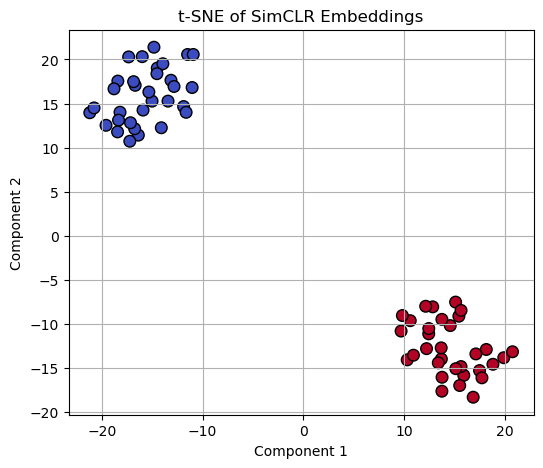

In [3]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Function to generate synthetic structured data (2 classes)
def generate_data(N=64):
    half = N // 2
    # Class 1: centered around +0.5
    class1 = torch.randn(half, 3, 16, 16) * 0.2 + 0.5
    # Class 2: centered around -0.5
    class2 = torch.randn(half, 3, 16, 16) * 0.2 - 0.5
    # Combine both classes
    data = torch.cat([class1, class2], dim=0)
    labels = torch.cat([torch.zeros(half), torch.ones(half)]).long()
    return data, labels

# Assume your SimCLR model is already trained and named `model`
# Generate new structured data for visualization
X, y = generate_data()

# Get embeddings from the model (no gradient needed)
with torch.no_grad():
    z = model(X).numpy()

# Apply t-SNE to reduce embeddings to 2D
tsne = TSNE(n_components=2, perplexity=10, random_state=42)
z_2d = tsne.fit_transform(z)

# Plot the t-SNE result with colors indicating the original classes
plt.figure(figsize=(6, 5))
plt.scatter(z_2d[:, 0], z_2d[:, 1], c=y, cmap="coolwarm", edgecolors="k", s=70)
plt.title("t-SNE of SimCLR Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()
